<a href="https://colab.research.google.com/github/Rachit23110261/ML_ASSIGNMENT_2_23110261_23110189_23110306/blob/main/ML_Assignment2_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [ ]:
import cv2
import matplotlib.pyplot as plt

!wget "https://raw.githubusercontent.com/Shriniket69/host/refs/heads/main/iit_gandhinagar-three_four%20(1).webp" -O iit.webp
# Load the image (1200x1600 resolution)
image_path = 'iit.webp'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
img_tensor = torch.from_numpy(image).permute(2, 0, 1)  # Change the dimension order to (C, H, W)

print("Shape of PyTorch tensor:", img_tensor.shape)

--2024-09-18 19:49:26--  https://raw.githubusercontent.com/Shriniket69/host/refs/heads/main/iit_gandhinagar-three_four%20(1).webp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235686 (230K) [image/webp]
Saving to: ‘iit.webp’

iit.webp            100%[===================>] 230.16K  --.-KB/s    in 0.009s  

2024-09-18 19:49:26 (25.1 MB/s) - ‘iit.webp’ saved [235686/235686]

Shape of PyTorch tensor: torch.Size([3, 1600, 1200])


In [ ]:
print('hello')

hello


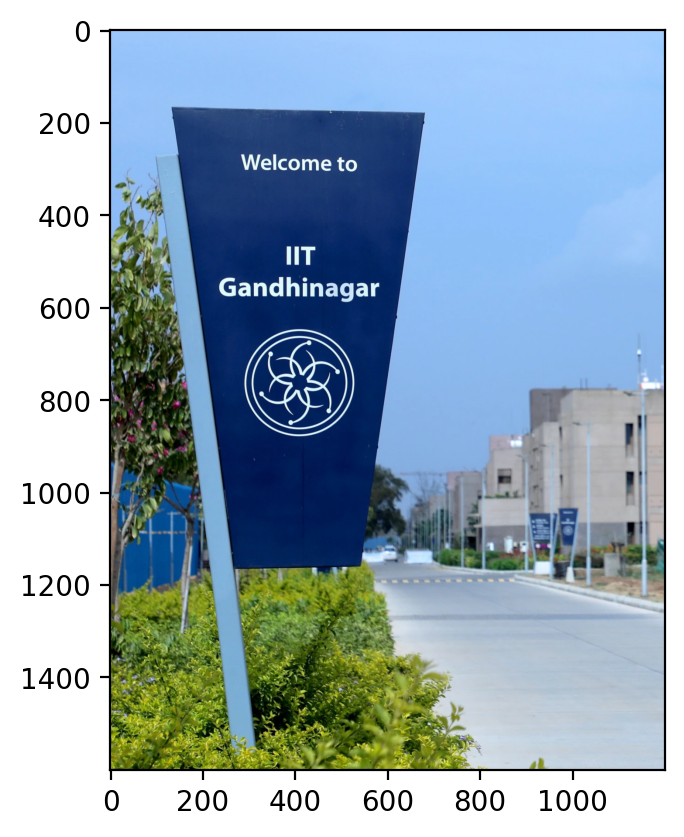

In [ ]:
plt.imshow(rearrange(img_tensor,'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img_tensor.reshape(-1, 1))
img_scaled = scaler_img.transform(img_tensor.reshape(-1, 1)).reshape(img_tensor.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)

(3, 1600, 1200)


In [ ]:
img_scaled=img_scaled.to(device)
# img_scaled

torch.Size([3, 400, 400])


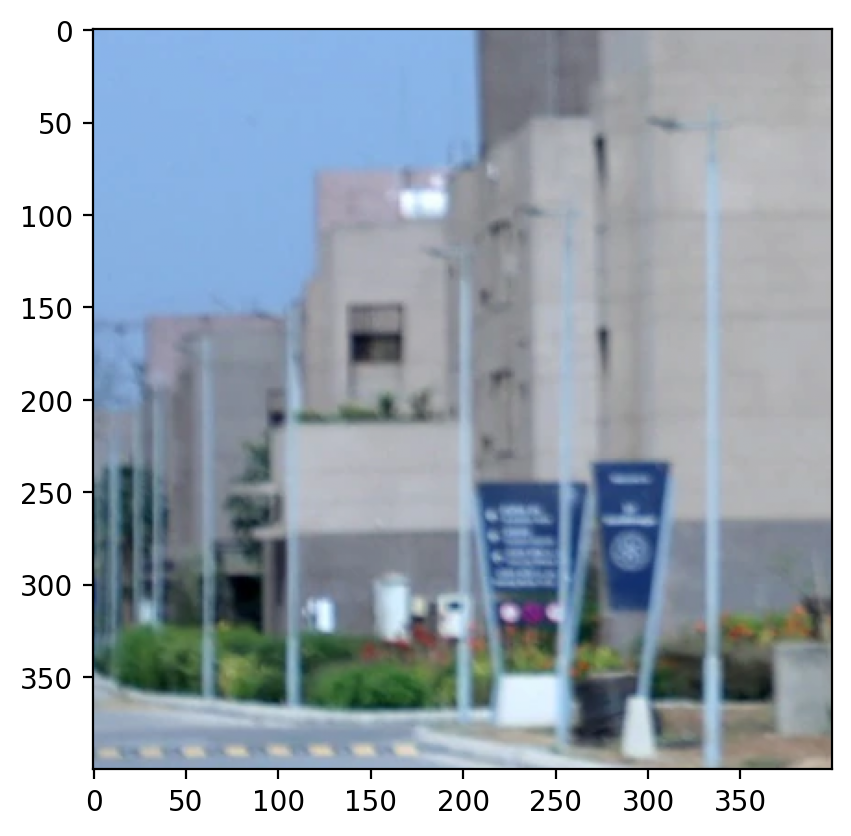

In [ ]:
crop=torchvision.transforms.functional.crop(img_scaled.to(device),800,700,400,400)
print(crop.shape)
plt.imshow(rearrange(crop,'c h w -> h w c').cpu().numpy())

In [ ]:
actual_img=crop

In [ ]:
import cv2
import torch

# Assuming 'crop' is a PyTorch tensor of shape [C, H, W]
# Convert the tensor to a NumPy array (convert to CPU and detach from the computational graph)
crop_numpy = crop.permute(1, 2, 0).cpu().numpy()  # Convert [C, H, W] -> [H, W, C] for OpenCV

# Resize using OpenCV
resized_crop = cv2.resize(crop_numpy, (200, 200))  # Resize to (width=200, height=200)

# If needed, convert the resized NumPy array back to a PyTorch tensor
resized_crop_tensor = torch.from_numpy(resized_crop).permute(2, 0, 1)  # Convert [H, W, C] -> [C, H, W]
crop=resized_crop_tensor

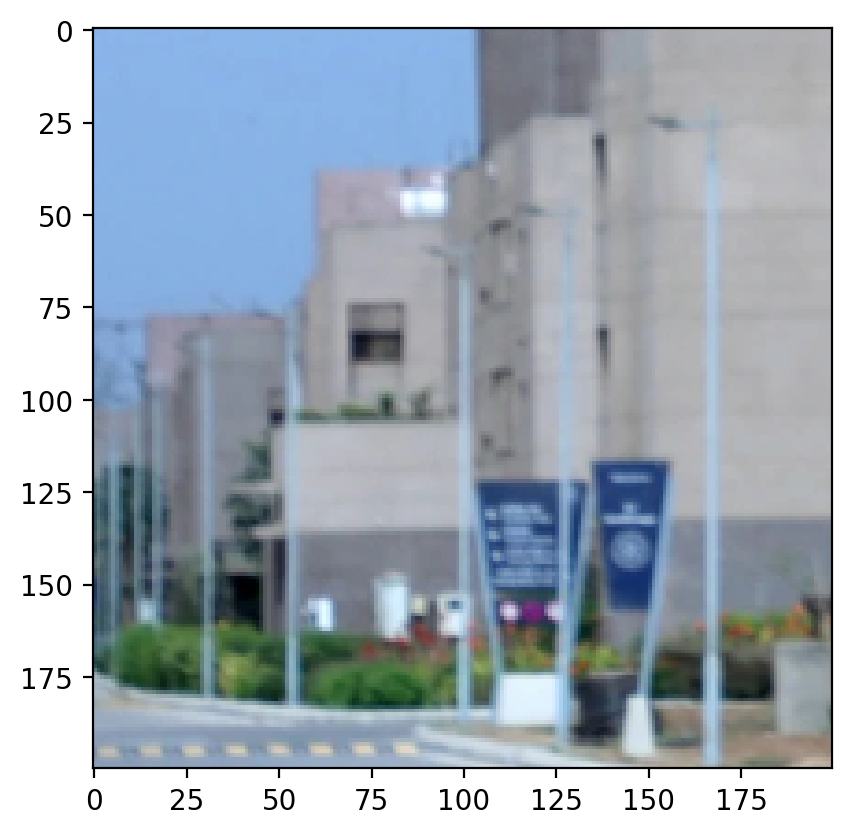

In [ ]:
plt.imshow(rearrange(crop,'c h w -> h w c'))

In [ ]:
crop = crop.to(device)

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape


(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
num_features=10000
sigma=0.008

In [ ]:
from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))

In [ ]:
# create RFF features
def create_rff_features(X,rff, num_features, sigma):
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
#     device2 = torch.device('cuda:1')
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
X_rff = create_rff_features(dog_X_scaled,rff, 40000, 0.008)

In [ ]:
X_rff.shape

torch.Size([40000, 10000])

In [ ]:
print(torch.min(X_rff), torch.max(X_rff))

tensor(-0.0141) tensor(0.0141)


In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
# device2=torch.device('cuda:0')
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.389062
Epoch 100 loss: 0.050088
Epoch 200 loss: 0.014299
Epoch 300 loss: 0.011028
Epoch 400 loss: 0.009464
Epoch 500 loss: 0.008332
Epoch 600 loss: 0.007469
Epoch 700 loss: 0.006795
Epoch 800 loss: 0.006261
Epoch 900 loss: 0.005833
Epoch 1000 loss: 0.005486
Epoch 1100 loss: 0.005203
Epoch 1200 loss: 0.004970
Epoch 1300 loss: 0.004774
Epoch 1400 loss: 0.004608
Epoch 1500 loss: 0.004464
Epoch 1600 loss: 0.004337
Epoch 1700 loss: 0.004224
Epoch 1800 loss: 0.004122
Epoch 1900 loss: 0.004028
Epoch 2000 loss: 0.003942
Epoch 2100 loss: 0.003862
Epoch 2200 loss: 0.003788
Epoch 2300 loss: 0.003719
Epoch 2400 loss: 0.003654


0.0035933959297835827

In [ ]:
crop.shape

torch.Size([3, 200, 200])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.inference_mode():
        outputs = net(X)
        print(outputs.shape)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    outputs=MinMaxScaler(feature_range=(0,1)).fit_transform(outputs.reshape(-1,1)).reshape(height,width,num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
#     ax0.imshow(outputs.cpu())
    ax0.imshow(outputs)

    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

torch.Size([40000, 3])


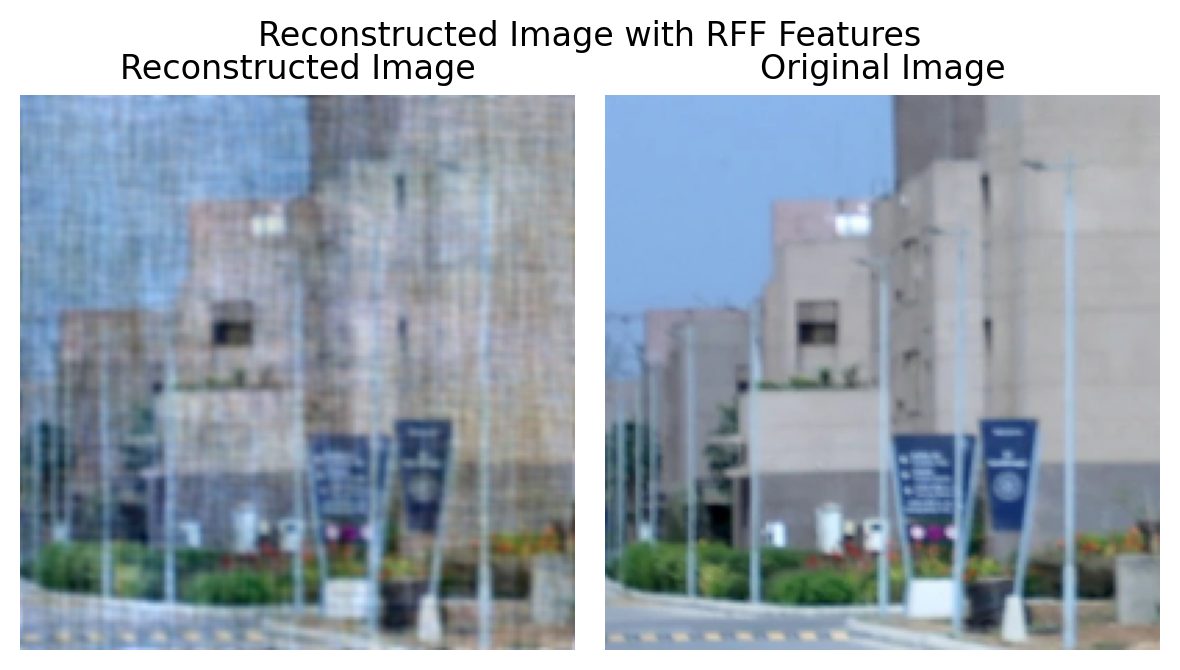

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


In [ ]:
dog_X.shape

torch.Size([40000, 2])

In [ ]:
def create_high_res_grid(img, scale_factor):
    num_channels, height, width = img.shape
    new_height, new_width = height * scale_factor, width * scale_factor
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
#     w_coords = torch.linspace(0,new_width-1,new_width).repeat(new_height, 1)
    w_coords=torch.arange(0, width, 1/scale_factor).repeat(new_height, 1)
#     h_coords = torch.linspace(0,new_height-1,new_height).repeat(new_width, 1).t()
    h_coords=torch.arange(0, height, 1/scale_factor).repeat(new_width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
#     print(w_coords)
#     print(h_coords)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    Y=rearrange(img, 'c h w -> (h w) c').float()
  # [new_height * new_width, 2]
    return X,Y

tensor([  0.0000,   0.5000,   1.0000,  ..., 198.5000, 199.0000, 199.5000])
tensor([  0.0000,   0.0000,   0.0000,  ..., 199.5000, 199.5000, 199.5000])
dog_X shape:  torch.Size([160000, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1728504..3.0720115].


torch.Size([160000, 10000])
torch.Size([3, 200, 200]) torch.Size([160000, 10000])
torch.Size([160000, 3])

torch.Size([400, 400, 3])


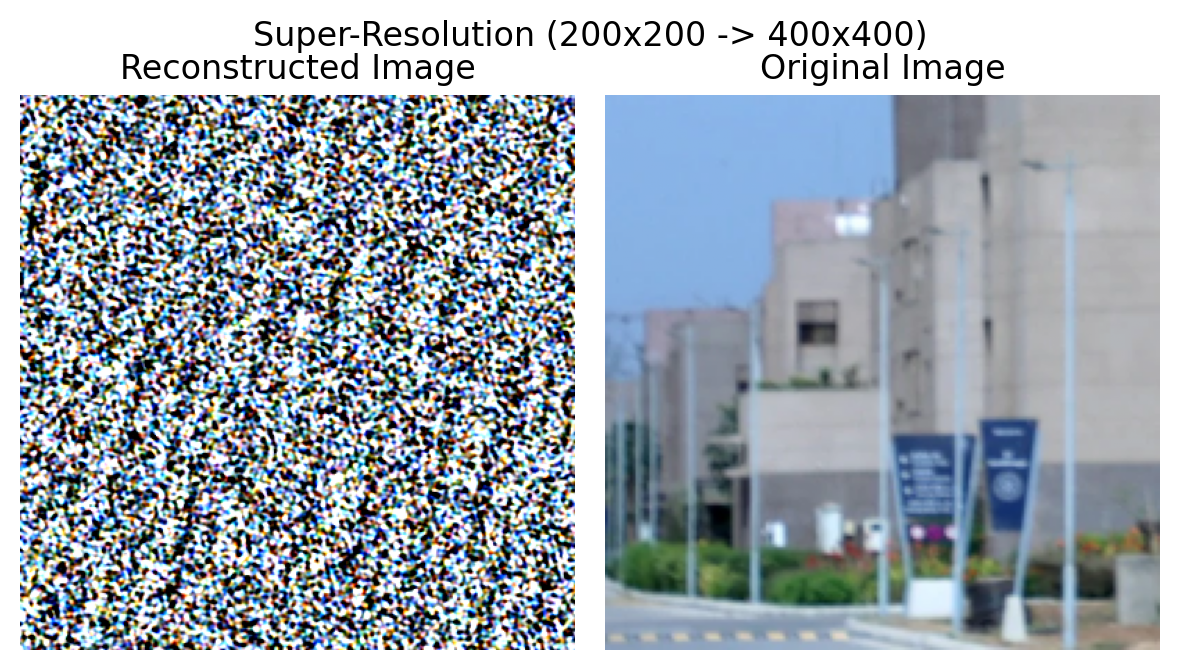

In [ ]:
# Create high-resolution coordinates for the 400x400 image
dog_X , Y= create_high_res_grid(crop,2)
print("dog_X shape: ", dog_X.shape)
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())
# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
# Create RFF features for high-resolution grid
X_rff_high_res = create_rff_features(dog_X_scaled,rff, num_features=40000, sigma=0.008)

print(X_rff_high_res.shape)

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.inference_mode():
        outputs = net(X)

        outputs = outputs.reshape(height*2, width*2, num_channels)
#         print()
#         print(outputs.shape)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
print(crop.shape,X_rff_high_res.shape)
# Plot the results
plot_reconstructed_and_original_image(crop,net,X_rff_high_res, title="Super-Resolution (200x200 -> 400x400)")

**STOP**

Epoch 0 loss: 0.390168
Epoch 100 loss: 0.041556
tensor([  0.0000,   0.5000,   1.0000,  ..., 198.5000, 199.0000, 199.5000])
tensor([  0.0000,   0.0000,   0.0000,  ..., 199.5000, 199.5000, 199.5000])


(tensor([[[0.5489, 0.6973, 0.8850],
          [0.5344, 0.7063, 0.9132],
          [0.5469, 0.6923, 0.8714],
          ...,
          [0.7013, 0.7144, 0.7322],
          [0.6814, 0.6840, 0.6897],
          [0.7048, 0.7166, 0.7315]],
 
         [[0.5425, 0.7078, 0.9085],
          [0.5540, 0.7500, 0.9883],
          [0.5485, 0.7097, 0.9045],
          ...,
          [0.7048, 0.7088, 0.7299],
          [0.7288, 0.7261, 0.7417],
          [0.6918, 0.6868, 0.7035]],
 
         [[0.5373, 0.6881, 0.8701],
          [0.5416, 0.7167, 0.9218],
          [0.5306, 0.6666, 0.8310],
          ...,
          [0.6729, 0.6833, 0.6997],
          [0.7020, 0.7037, 0.7122],
          [0.6905, 0.6974, 0.7123]],
 
         ...,
 
         [[0.5198, 0.5790, 0.6523],
          [0.5722, 0.6296, 0.6964],
          [0.5667, 0.6012, 0.6512],
          ...,
          [0.6952, 0.6506, 0.6101],
          [0.6948, 0.6377, 0.5938],
          [0.7147, 0.6637, 0.6358]],
 
         [[0.5419, 0.6214, 0.7167],
          [0

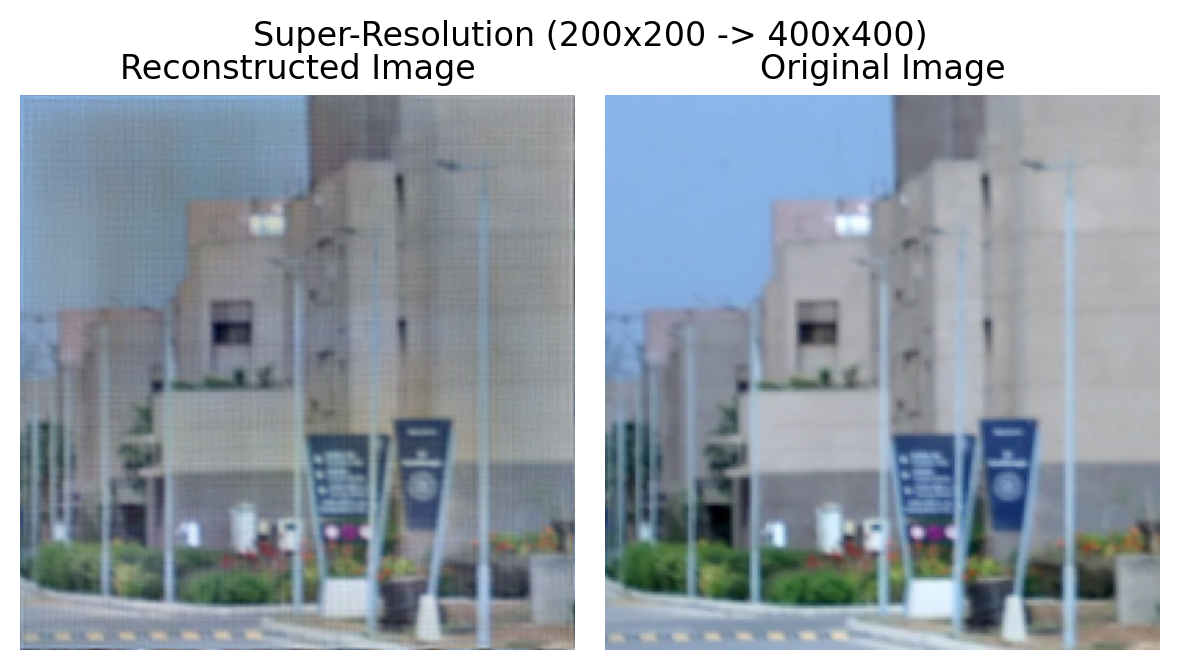

In [ ]:
upscale_image(crop,40000,0.008,0.005,200,2)

In [ ]:
num_features=40000
learning_rate=0.005
sigma=0.008
epochs=2500
X, Y = create_coordinate_map(crop)
Y = Y.to(device)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
X_scaled = torch.tensor(scaler_X.transform(X.cpu())).to(device).float()

rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
X_rff = torch.tensor(rff.fit_transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, learning_rate, X_rff, Y, epochs)

num_channels, height, width = crop.shape

with torch.inference_mode():
    outputs_og = net(X_rff)
    outputs_og = outputs_og.reshape(height, width, num_channels)

del X_rff, X, Y, X_scaled

Epoch 0 loss: 0.391192
Epoch 100 loss: 0.039590
Epoch 200 loss: 0.004978
Epoch 300 loss: 0.001880
Epoch 400 loss: 0.000866
Epoch 500 loss: 0.000404
Epoch 600 loss: 0.000190
Epoch 700 loss: 0.000092
Epoch 800 loss: 0.000050
Epoch 900 loss: 0.000032
Epoch 1000 loss: 0.000025
Epoch 1100 loss: 0.000022
Epoch 1200 loss: 0.000020
Epoch 1300 loss: 0.000019
Epoch 1400 loss: 0.000019
Epoch 1500 loss: 0.000019
Epoch 1600 loss: 0.000018
Epoch 1700 loss: 0.000018
Epoch 1800 loss: 0.000018
Epoch 1900 loss: 0.000018
Epoch 2000 loss: 0.000017
Epoch 2100 loss: 0.000017
Epoch 2200 loss: 0.000017
Epoch 2300 loss: 0.000017
Epoch 2400 loss: 0.000017


In [ ]:
def upscale_image(crop: torch.Tensor, num_features: int, sigma: float, learning_rate: float, epochs: int, Scale: int) -> torch.Tensor:
#     X, Y = create_coordinate_map(crop)
#     Y = Y.to(device)

#     scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
#     X_scaled = torch.tensor(scaler_X.transform(X.cpu())).to(device).float()

#     rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
#     X_rff = torch.tensor(rff.fit_transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
#     net = LinearModel(X_rff.shape[1], 3)
#     net.to(device)

#     train(net, learning_rate, X_rff, Y, epochs)

#     num_channels, height, width = crop.shape

#     with torch.inference_mode():
#         outputs_og = net(X_rff)
#         outputs_og = outputs_og.reshape(height, width, num_channels)

#     del X_rff, X, Y, X_scaled

    X_up, Y_up = create_high_res_grid(crop, Scale)
    Y_up.to(device)

    X_up_scaled = torch.tensor(scaler_X.transform(X_up.cpu())).to(device).float()

    X_rff_up = torch.tensor(rff.transform(X_up_scaled.cpu().numpy()), dtype=torch.float32).to(device)

    num_channels, height, width = crop.shape
    height *= Scale
    width *= Scale

    with torch.inference_mode():
        outputs = net(X_rff_up)
        outputs = outputs.reshape(height, width, num_channels)
        fig = plt.figure(figsize=(6, 4))

    outputs=MinMaxScaler(feature_range=(0,1)).fit_transform(outputs.reshape(-1,1)).reshape(height,width,num_channels)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(rearrange(outputs,'c h w -> c h w'))
#     ax0.xticks(ticks=np.arange(0, image.shape[1], 2))
#     ax0.yticks(ticks=np.arange(0, image.shape[0], 2))
    ax0.set_title("Super Resolution Image")
    ax1.imshow(rearrange(crop.cpu(),'c h w -> h w c'))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle("Super-Resolution (200x200 -> 400x400)", y=0.9)
    plt.tight_layout()
    return outputs_og, outputs

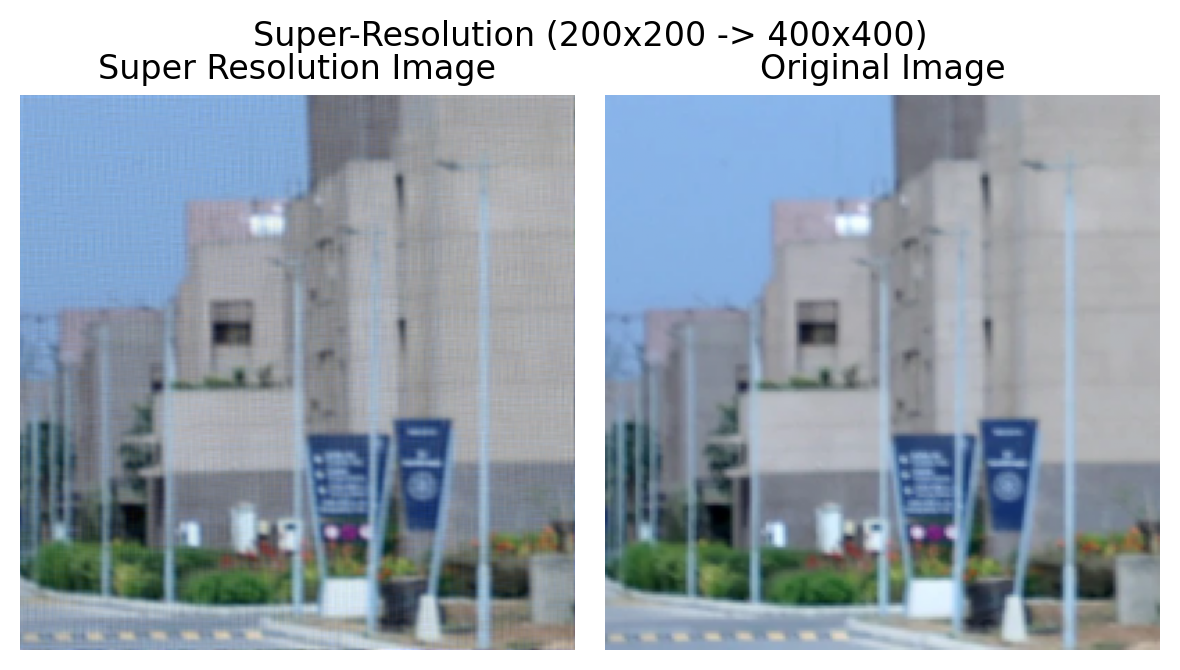

In [ ]:
outputs_og,outputs=upscale_image(crop,40000,0.008,0.005,200,2)

Part 2 comparision of super resolution image vs image that we took initially

RMSE Value

In [ ]:
actual_img=rearrange(actual_img,'c h w -> h w c')

In [ ]:
def rmse(actual:torch.tensor,pred):
    c=0
    n=0
#     for i in range(actual.shape[0]):
#         for j in range(actual.shape[1]):
#             for k in range(actual.shape[2]):
#                 c+=(pred[i,j,k]-actual[i,j,k])**2
#                 n+=1
#     value=(c/n)**0.5
    pred=torch.tensor(pred)
    c=(pred-actual)**2
    value=torch.mean(c)
    value=torch.sqrt(value)
    print('RMSE:',value)


In [ ]:
rmse(outputs,actual_img)

RMSE: tensor(0.0348, dtype=torch.float64)


SNR

In [ ]:
def snr(img):
    noise_intensity=0.1
    mean=torch.mean(img)
    noise=torch.randn(img.shape)*noise_intensity
    diff=img-noise
    std=diff.std()
    snr=mean/std
    return snr

In [ ]:
snr_og=snr(actual_img)
snr_pred=snr(torch.tensor(outputs))
print('SNR of original image:',snr_og)
print('SNR of reconstructed image',snr_pred)

SNR of original image: tensor(3.0579, dtype=torch.float64)
SNR of reconstructed image tensor(3.1269, dtype=torch.float64)
